In [1]:
import game_play_rule as game
import game_strategies as stra
import validation_setting as valid

## Validation for the random stragegies
This script simulates a dice game involving 5 players, where each player starts with 5 dice and employs random strategies. The goal is to validate various aspects of the game under random conditions, such as distribution of dice rolls, win rates, and "liar" call patterns, without adopting any specific strategic behavior.
### Purpose of the Simulation
#### Establish Baselines:
This simulation provides a baseline for analyzing game dynamics under random strategies.
#### Test Randomness:
Check if dice rolls follow a uniform distribution.
Verify if the starting player selection is random.
Ensure no bias exists in win rates when using random strategies.
#### Analyze "Liar" Calls:
Identify patterns in "liar" calls, including their frequency and validity.
Explore relationships between bid size, dice count, and call validity.


In [20]:
# Simulate the game with 5 players and each player has 5 dices(everyone uses random strategies)
num_players = 5
num_dice = 5
times = 1000
validation_test = valid.Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice,Strategies)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4086          16.34%
1           2        4188          16.75%
2           3        4142          16.57%
3           4        4099          16.40%
4           5        4375          17.50%
5           6        4110          16.44%



win rate distribution
    Player  Wins Win Rate
0  player0   204   20.40%
1  player1   215   21.50%
2  player2   207   20.70%
3  player3   167   16.70%
4  player4   207   20.70%



first player distribution
    Player  Start times Start rate
0  player0          197     19.70%
1  player1          185     18.50%
2  player2          215     21.50%
3  player3          196     19.60%
4  player4          207     20.70%



challenge bid distribution
    quantity  face_value  times  valid_times  invalid_times
65       1.0           6     65           65              0
14       0.2           3     31            1             30
29       0.4           6     31           18             1

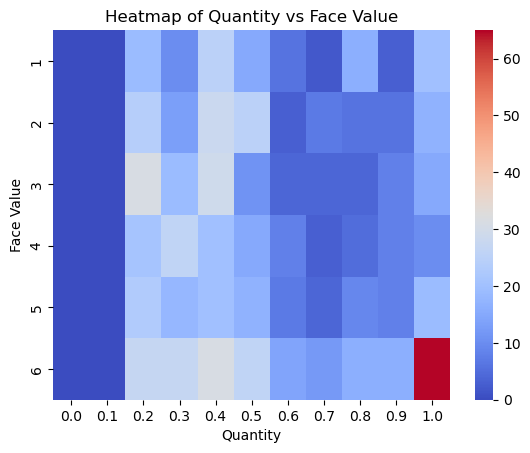




liar valid rate
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2         145           13            132    0.089655
0.3         113           37             76    0.327434
0.4         153           99             54    0.647059
0.5         109           92             17    0.844037
0.6          42           39              3    0.928571
0.7          32           32              0    1.000000
0.8          56           56              0    1.000000
0.9          49           49              0    1.000000
1.0         146          146              0    1.000000


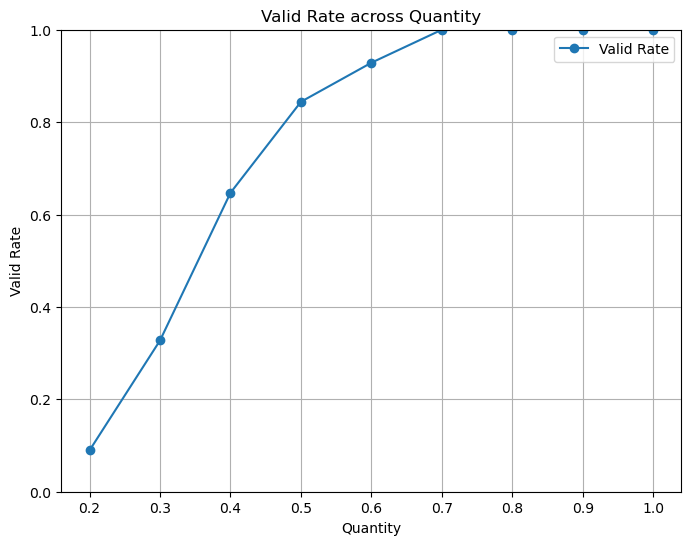

valid_call_rate
valid_call_rate


,player,valid_calls,invalid_calls,total_calls,valid_call_rate
0,player0,563,282,845,66.63%
1,player1,526,244,770,68.31%
2,player2,529,259,788,67.13%
3,player3,507,284,791,64.10%
4,player4,541,265,806,67.12%


In [22]:
#check 
print("dice distribution")
print(validation_test.check_original_dices())
print("\n" * 2)
print("win rate distribution")
print(validation_test.check_win_rate())
print("\n" * 2)
print("first player distribution")
print(validation_test.check_first_player())
print("\n" * 2)
print("challenge bid distribution")
validation_test.check_liar_call(0)
print("\n" * 2)
print("liar valid rate")
validation_test.check_liar_valid_rate(0)
print("valid_call_rate")
validation_test.check_liar_win_rate()
print("valid_call_rate")
validation_test.check_liar_win_rate()

### 1. Test for the First-Caller Hypothesis:

The First-Caller Advantage Hypothesis suggests that when the probability distribution of dice combinations aligns with statistical expectations, the player who initiates the bidding (the first caller) tends to have a higher win rate compared to their opponents.

In [24]:
# Simulate the game with 5 players and each player has 5 dice (everyone uses random strategies,but the first player always bid first)
num_players = 5
num_dice = 5
times = 1000  
validation_test = valid.Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice, Strategies, first_caller = 0)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4142          16.57%
1           2        4091          16.36%
2           3        4253          17.01%
3           4        4234          16.94%
4           5        4068          16.27%
5           6        4212          16.85%



win rate distribution
None
    Player  Wins Win Rate
0  player0   200   20.00%
1  player1   142   14.20%
2  player2   224   22.40%
3  player3   187   18.70%
4  player4   247   24.70%



first player distribution
    Player  Start times Start rate
0  player0         1000    100.00%
1  player1            0      0.00%
2  player2            0      0.00%
3  player3            0      0.00%
4  player4            0      0.00%



challenge bid distribution
    quantity  face_value  times  valid_times  invalid_times
65       1.0           6     73           73              0
33       0.5           4     25           20              5
24       0.4           1     25           25         

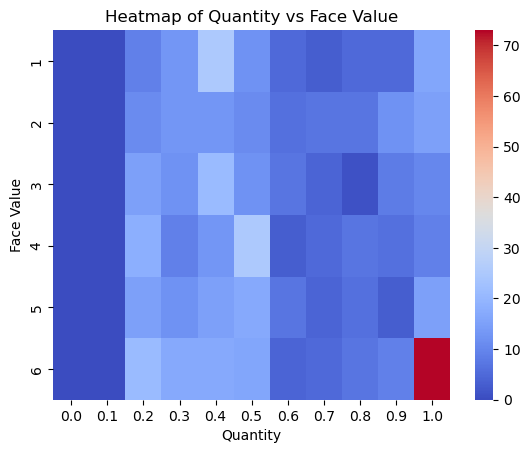




liar valid rate
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2          89            8             81    0.089888
0.3          76           20             56    0.263158
0.4         104           66             38    0.634615
0.5          93           73             20    0.784946
0.6          32           32              0    1.000000
0.7          28           28              0    1.000000
0.8          33           33              0    1.000000
0.9          43           43              0    1.000000
1.0         138          138              0    1.000000


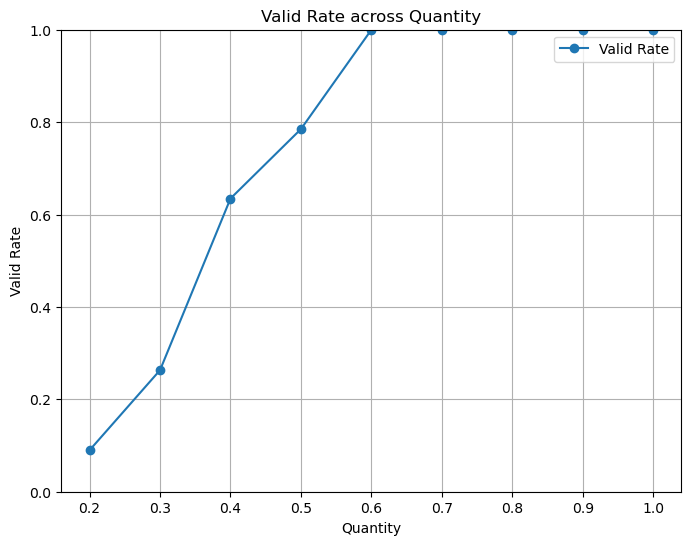

valid_call_rate


,player,valid_calls,invalid_calls,total_calls,valid_call_rate
0,player0,441,195,636,69.34%
1,player1,522,398,920,56.74%
2,player2,579,189,768,75.39%
3,player3,597,302,899,66.41%
4,player4,580,197,777,74.65%


In [26]:
#check 
print("dice distribution")
print(validation_test.check_original_dices())
print("\n" * 2)
print(print("win rate distribution"))
print(validation_test.check_win_rate())
print("\n" * 2)
print("first player distribution")
print(validation_test.check_first_player())
print("\n" * 2)
print("challenge bid distribution")
validation_test.check_liar_call(0)
print("\n" * 2)
print("liar valid rate")
validation_test.check_liar_valid_rate(0)
print("valid_call_rate")
validation_test.check_liar_win_rate()

### 2. Test Hypothesis for Normal_Threshold-Based Strategy

The Threshold-Based Call Hypothesis suggests that, under typical game rules, the player employing a threshold-based strategy (e.g., always calling "liar" when the opponent's bid exceeds half the total dice count of any face value) will have a higher success rate compared to players using purely random strategies.

This hypothesis examines whether such a strategy gives the player a measurable advantage over opponents.

In [28]:
# Simulate the game with 5 players and each player has 5 dice (some players use random strategies and one uses normal_threshold strategy)
num_players = 5
num_dice = 5
times = 1000  
validation_test = valid.Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    if i == 0:
        Strategies[i] = stra.Strategy(liar_threshold = "Normal")
    else:
        Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice, Strategies, first_caller = -1, special_rule = False)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4219          16.88%
1           2        4041          16.16%
2           3        4208          16.83%
3           4        4217          16.87%
4           5        4204          16.82%
5           6        4111          16.44%



win rate distribution
None
    Player  Wins Win Rate
0  player0   325   32.50%
1  player1   175   17.50%
2  player2   170   17.00%
3  player3   164   16.40%
4  player4   166   16.60%



first player distribution
    Player  Start times Start rate
0  player0          212     21.20%
1  player1          177     17.70%
2  player2          235     23.50%
3  player3          173     17.30%
4  player4          203     20.30%



challenge bid distribution for player0
    quantity  face_value  times  valid_times  invalid_times
65       1.0           6     80           80              0
60       1.0           1     46           46              0
63       1.0           4     44          

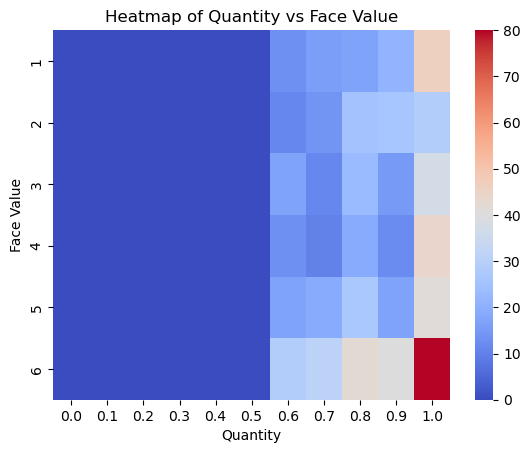




challenge bid distribution for player1
    quantity  face_value  times  valid_times  invalid_times
65       1.0           6     34           34              0
29       0.4           6     32           18             14
27       0.4           4     28           23              5
15       0.2           4     28            3             25
16       0.2           5     26            0             26
..       ...         ...    ...          ...            ...
5        0.0           6      0            0              0
11       0.1           6      0            0              0
10       0.1           5      0            0              0
9        0.1           4      0            0              0
0        0.0           1      0            0              0

[66 rows x 5 columns]


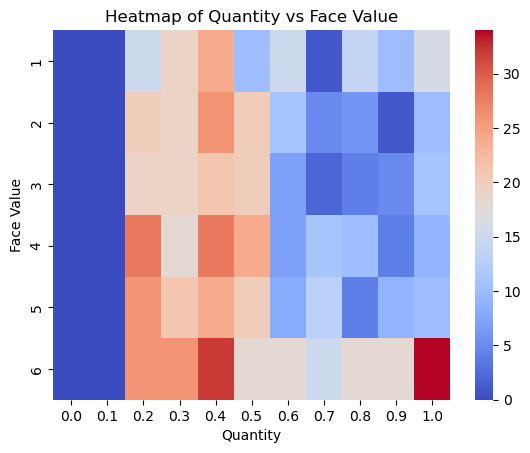

liar valid rate for player0
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2           0            0              0         NaN
0.3           0            0              0         NaN
0.4           0            0              0         NaN
0.5           0            0              0         NaN
0.6         100           98              2    0.980000
0.7         101          100              1    0.990099
0.8         153          153              0    1.000000
0.9         131          131              0    1.000000
1.0         277          277              0    1.000000


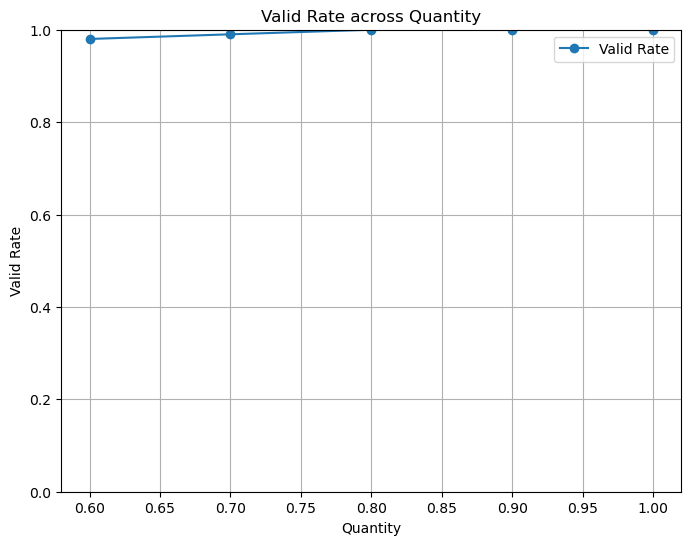




liar valid rate for player1
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2         134           11            123    0.082090
0.3         122           39             83    0.319672
0.4         155          103             52    0.664516
0.5         112           98             14    0.875000
0.6          66           63              3    0.954545
0.7          47           47              0    1.000000
0.8          56           56              0    1.000000
0.9          47           47              0    1.000000
1.0          90           90              0    1.000000


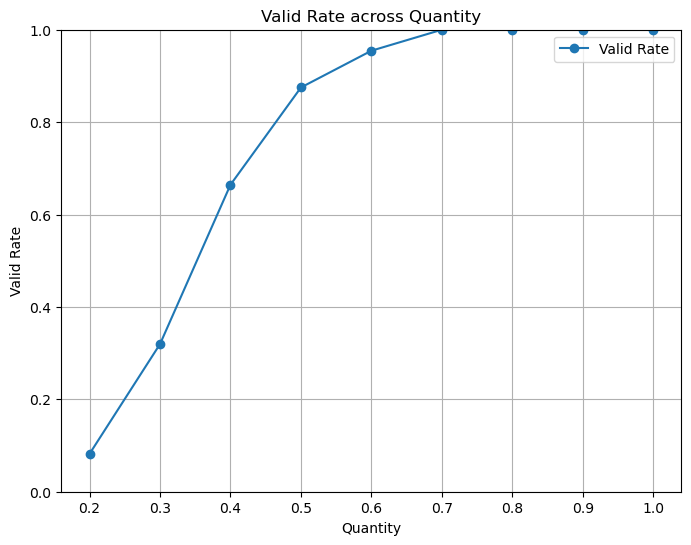

valid_call_rate


,player,valid_calls,invalid_calls,total_calls,valid_call_rate
0,player0,759,3,762,99.61%
1,player1,554,275,829,66.83%
2,player2,566,266,832,68.03%
3,player3,564,257,821,68.70%
4,player4,518,238,756,68.52%


In [30]:
#check 
print("dice distribution")
print(validation_test.check_original_dices())
print("\n" * 2)
print(print("win rate distribution"))
print(validation_test.check_win_rate())
print("\n" * 2)
print("first player distribution")
print(validation_test.check_first_player())
print("\n" * 2)
print("challenge bid distribution for player0")
validation_test.check_liar_call(0)
print("\n" * 2)
print("challenge bid distribution for player1")
validation_test.check_liar_call(1)
print("liar valid rate for player0")
validation_test.check_liar_valid_rate(0)
print("\n" * 2)
print("liar valid rate for player1")
validation_test.check_liar_valid_rate(1)
print("valid_call_rate")
validation_test.check_liar_win_rate()

### 4. Test for Optimal-Threshold Strategy Hypothesis

The Optimal-Threshold Hypothesis suggests that a player who calls "liar" based on an optimal threshold derived from their own dice count and statistical expectations of the remaining dice will outperform opponents using random strategies. This strategy calculates a dynamic threshold to decide whether to challenge a bid, potentially increasing the success rate of "liar" calls.

In [36]:
# Simulate the game with 5 players and each player has 5 dice (some players use random strategies and one uses Optimal_threshold strategy)
num_players = 5
num_dice = 5
times = 1000  
validation_test = valid.Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    if i == 0:
        Strategies[i] = stra.Strategy(liar_threshold = "Optimal")
    else:
        Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice, Strategies, first_caller = -1, special_rule = False)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4098          16.39%
1           2        4120          16.48%
2           3        4174          16.70%
3           4        4132          16.53%
4           5        4208          16.83%
5           6        4268          17.07%



win rate distribution
None
    Player  Wins Win Rate
0  player0   387   38.70%
1  player1   155   15.50%
2  player2   148   14.80%
3  player3   144   14.40%
4  player4   166   16.60%



first player distribution
    Player  Start times Start rate
0  player0          187     18.70%
1  player1          204     20.40%
2  player2          193     19.30%
3  player3          211     21.10%
4  player4          205     20.50%



challenge bid distribution for player0
    quantity  face_value  times  valid_times  invalid_times
65       1.0           6     66           66              0
64       1.0           5     45           45              0
63       1.0           4     37          

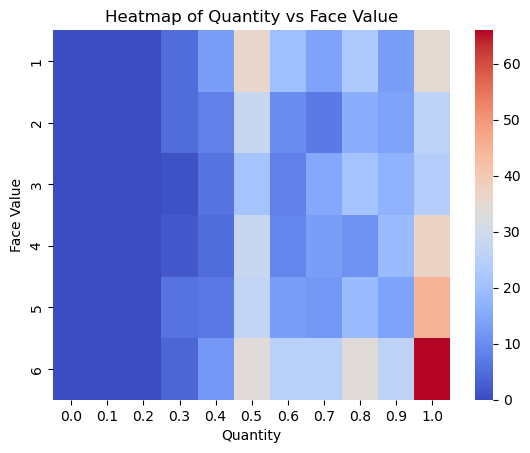




challenge bid distribution for player1
    quantity  face_value  times  valid_times  invalid_times
29       0.4           6     39           23             16
65       1.0           6     32           32              0
17       0.2           6     32            1             31
16       0.2           5     30            0             30
31       0.5           2     29           25              4
..       ...         ...    ...          ...            ...
5        0.0           6      0            0              0
11       0.1           6      0            0              0
10       0.1           5      0            0              0
9        0.1           4      0            0              0
0        0.0           1      0            0              0

[66 rows x 5 columns]


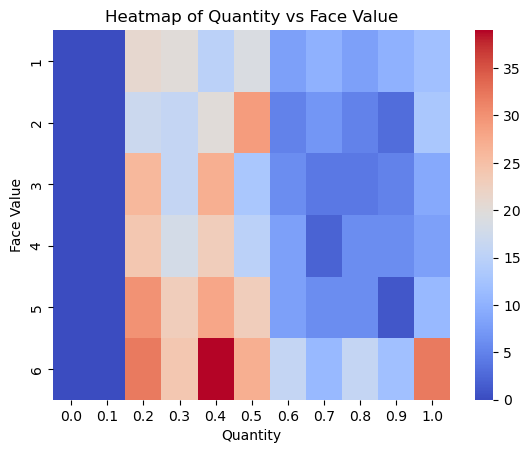

liar valid rate for player0
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2           0            0              0         NaN
0.3          23           19              4    0.826087
0.4          51           45              6    0.882353
0.5         174          164             10    0.942529
0.6          85           85              0    1.000000
0.7          86           84              2    0.976744
0.8         124          124              0    1.000000
0.9         103          103              0    1.000000
1.0         233          233              0    1.000000


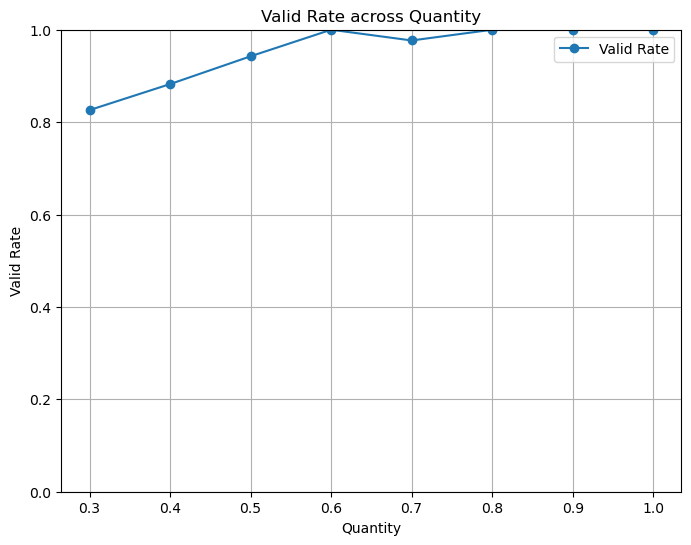




liar valid rate for player1
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2         150           12            138    0.080000
0.3         117           43             74    0.367521
0.4         152           91             61    0.598684
0.5         126          110             16    0.873016
0.6          51           49              2    0.960784
0.7          40           39              1    0.975000
0.8          45           45              0    1.000000
0.9          37           37              0    1.000000
1.0          85           85              0    1.000000


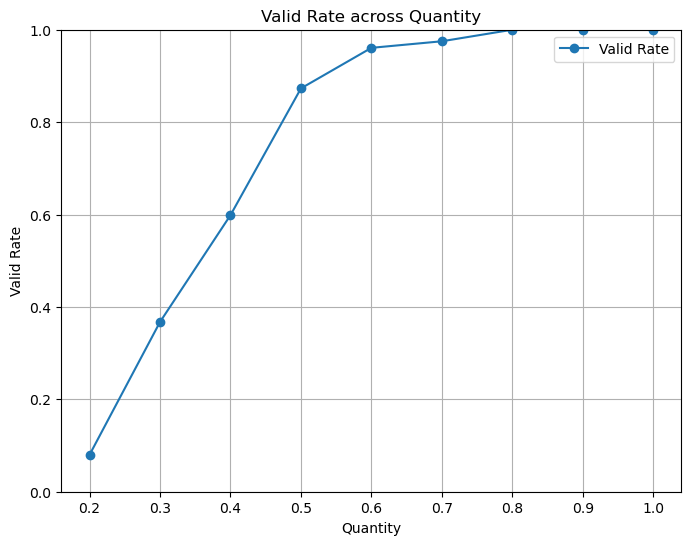

valid_call_rate


,player,valid_calls,invalid_calls,total_calls,valid_call_rate
0,player0,857,22,879,97.50%
1,player1,511,292,803,63.64%
2,player2,504,254,758,66.49%
3,player3,552,249,801,68.91%
4,player4,530,229,759,69.83%


In [38]:
#check 
print("dice distribution")
print(validation_test.check_original_dices())
print("\n" * 2)
print(print("win rate distribution"))
print(validation_test.check_win_rate())
print("\n" * 2)
print("first player distribution")
print(validation_test.check_first_player())
print("\n" * 2)
print("challenge bid distribution for player0")
validation_test.check_liar_call(0)
print("\n" * 2)
print("challenge bid distribution for player1")
validation_test.check_liar_call(1)
print("liar valid rate for player0")
validation_test.check_liar_valid_rate(0)
print("\n" * 2)
print("liar valid rate for player1")
validation_test.check_liar_valid_rate(1)
print("valid_call_rate")
validation_test.check_liar_win_rate()

### 3. Test Hypothesis for Prefer-Bid Strategy
The Prefer-Bid Hypothesis suggests that a player who prioritizes bidding using the face value of the dice they hold in the highest quantity will outperform opponents using random strategies. This hypothesis assumes that leveraging personal dice knowledge provides a statistical advantage in the game.

In [43]:
# Simulate the game with 5 players and each player has 5 dice (some players use random strategies and one uses prefer_bid strategy)
num_players = 5
num_dice = 5
times = 1000  
validation_test = valid.Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    if i == 0:
        Strategies[i] = stra.Strategy(prefer_bid = True)
    else:
        Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice, Strategies, first_caller = -1, special_rule = False)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4153          16.61%
1           2        4127          16.51%
2           3        4153          16.61%
3           4        4162          16.65%
4           5        4226          16.90%
5           6        4179          16.72%



win rate distribution
None
    Player  Wins Win Rate
0  player0   329   32.90%
1  player1   153   15.30%
2  player2   171   17.10%
3  player3   165   16.50%
4  player4   182   18.20%



first player distribution
    Player  Start times Start rate
0  player0          203     20.30%
1  player1          203     20.30%
2  player2          196     19.60%
3  player3          212     21.20%
4  player4          186     18.60%



challenge bid distribution for player0
    quantity  face_value  times  valid_times  invalid_times
65       1.0           6     57           57              0
25       0.4           2     34           15             19
24       0.4           1     30          

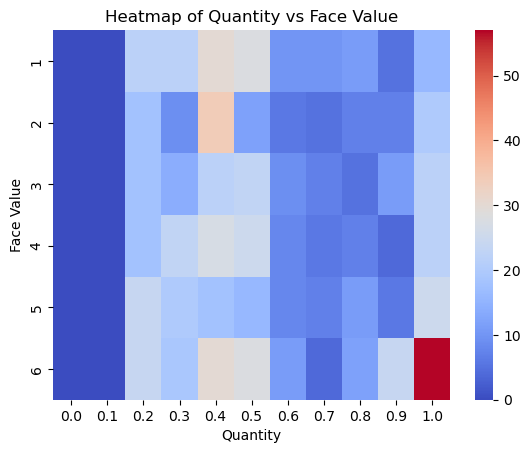




challenge bid distribution for player1
    quantity  face_value  times  valid_times  invalid_times
25       0.4           2     40           13             27
31       0.5           2     38           27             11
32       0.5           3     37           28              9
19       0.3           2     35            6             29
65       1.0           6     35           35              0
..       ...         ...    ...          ...            ...
8        0.1           3      0            0              0
11       0.1           6      0            0              0
10       0.1           5      0            0              0
9        0.1           4      0            0              0
0        0.0           1      0            0              0

[66 rows x 5 columns]


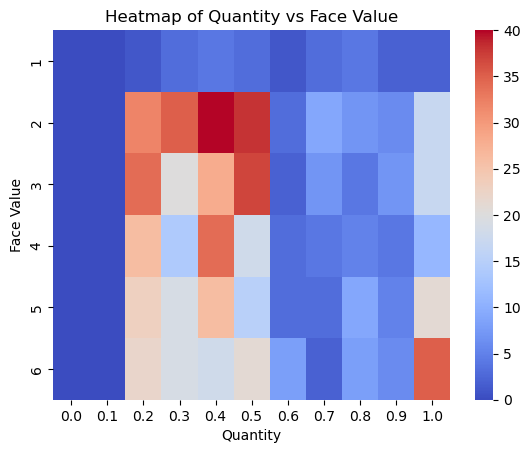

liar valid rate for player0
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2         124           12            112    0.096774
0.3         107           36             71    0.336449
0.4         161           93             68    0.577640
0.5         132          110             22    0.833333
0.6          52           48              4    0.923077
0.7          39           38              1    0.974359
0.8          53           53              0    1.000000
0.9          57           57              0    1.000000
1.0         162          162              0    1.000000


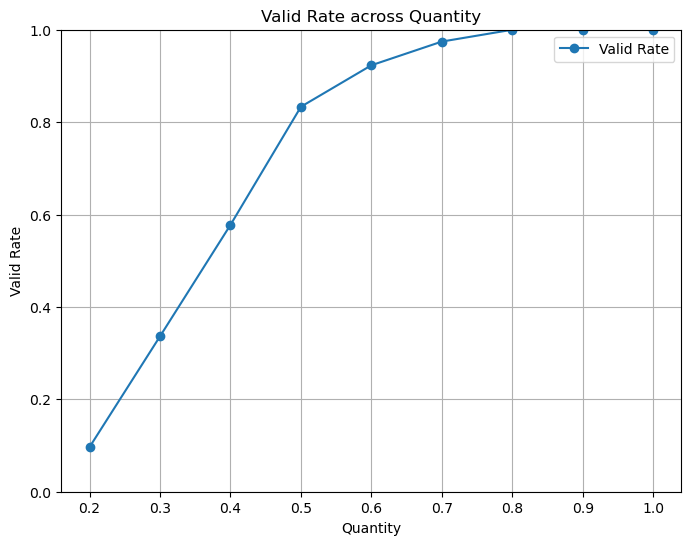




liar valid rate for player1
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2         138            3            135    0.021739
0.3         110           14             96    0.127273
0.4         150           50            100    0.333333
0.5         132           98             34    0.742424
0.6          20           19              1    0.950000
0.7          28           27              1    0.964286
0.8          37           37              0    1.000000
0.9          30           30              0    1.000000
1.0         103          103              0    1.000000


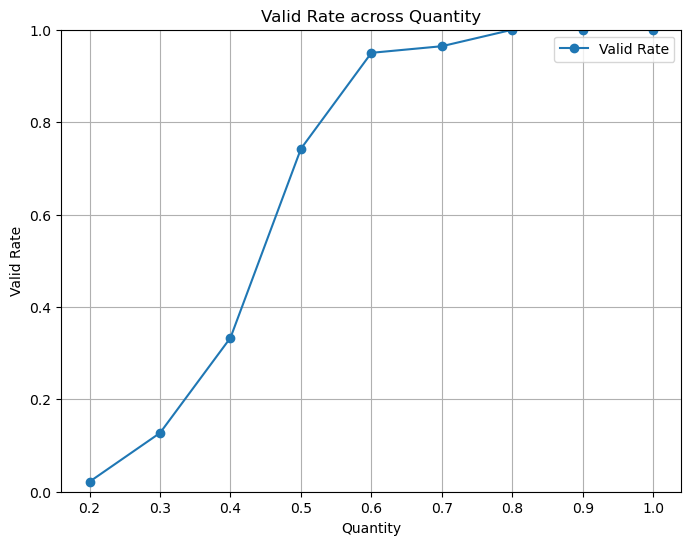

valid_call_rate


,player,valid_calls,invalid_calls,total_calls,valid_call_rate
0,player0,609,278,887,68.66%
1,player1,381,367,748,50.94%
2,player2,436,296,732,59.56%
3,player3,513,304,817,62.79%
4,player4,527,289,816,64.58%


In [47]:
#check 
print("dice distribution")
print(validation_test.check_original_dices())
print("\n" * 2)
print(print("win rate distribution"))
print(validation_test.check_win_rate())
print("\n" * 2)
print("first player distribution")
print(validation_test.check_first_player())
print("\n" * 2)
print("challenge bid distribution for player0")
validation_test.check_liar_call(0)
print("\n" * 2)
print("challenge bid distribution for player1")
validation_test.check_liar_call(1)
print("liar valid rate for player0")
validation_test.check_liar_valid_rate(0)
print("\n" * 2)
print("liar valid rate for player1")
validation_test.check_liar_valid_rate(1)
print("valid_call_rate")
validation_test.check_liar_win_rate()

### 5. Test for prefer_bid combinging normal_threshold Strategy
The Combined Prefer-Bid and Normal-Threshold Hypothesis suggests that a player who use prefer_bid strategy and normal_threshold strategy at the same time will achieve a higher success rate compared to opponents using only random strategies. This combined strategy leverages personal dice knowledge for bidding and a statistical threshold for challenging.

In [57]:
# Simulate the game with 5 players and each player has 5 dice (some players use random strategies and one uses normal_threshold and prefer_bid strategy)
num_players = 5
num_dice = 5
times = 1000  
validation_test = valid.Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    if i == 0:
        Strategies[i] = stra.Strategy(liar_threshold = "Normal",prefer_bid = True)
    else:
        Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice, Strategies, first_caller = -1, special_rule = False)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4141          16.56%
1           2        4145          16.58%
2           3        4220          16.88%
3           4        4245          16.98%
4           5        4139          16.56%
5           6        4110          16.44%



win rate distribution
None
    Player  Wins Win Rate
0  player0   546   54.60%
1  player1    90    9.00%
2  player2   122   12.20%
3  player3   119   11.90%
4  player4   123   12.30%



first player distribution
    Player  Start times Start rate
0  player0          182     18.20%
1  player1          197     19.70%
2  player2          213     21.30%
3  player3          208     20.80%
4  player4          200     20.00%



challenge bid distribution for player0
    quantity  face_value  times  valid_times  invalid_times
65       1.0           6     85           85              0
53       0.8           6     52           52              0
64       1.0           5     48          

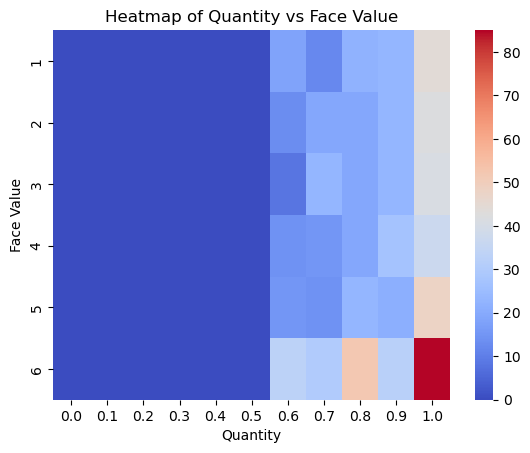




challenge bid distribution for player1
    quantity  face_value  times  valid_times  invalid_times
15       0.2           4     43            0             43
25       0.4           2     42           18             24
17       0.2           6     38            2             36
31       0.5           2     38           26             12
14       0.2           3     36            2             34
..       ...         ...    ...          ...            ...
36       0.6           1      0            0              0
10       0.1           5      0            0              0
9        0.1           4      0            0              0
11       0.1           6      0            0              0
0        0.0           1      0            0              0

[66 rows x 5 columns]


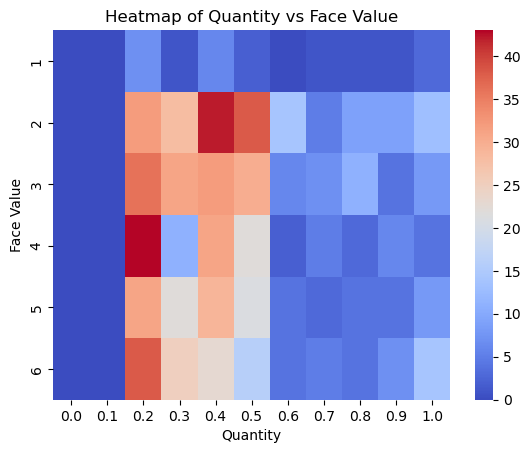

liar valid rate for player0
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2           0            0              0         NaN
0.3           0            0              0         NaN
0.4           0            0              0         NaN
0.5           0            0              0         NaN
0.6         101           97              4    0.960396
0.7         113          110              3    0.973451
0.8         154          154              0    1.000000
0.9         149          149              0    1.000000
1.0         297          297              0    1.000000


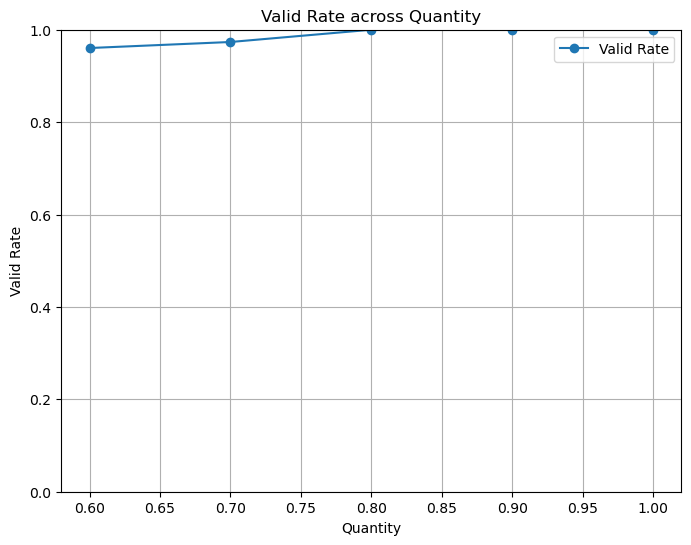




liar valid rate for player1
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2         187            9            178    0.048128
0.3         118            8            110    0.067797
0.4         163           61            102    0.374233
0.5         129          100             29    0.775194
0.6          30           27              3    0.900000
0.7          26           26              0    1.000000
0.8          32           32              0    1.000000
0.9          31           31              0    1.000000
1.0          50           50              0    1.000000


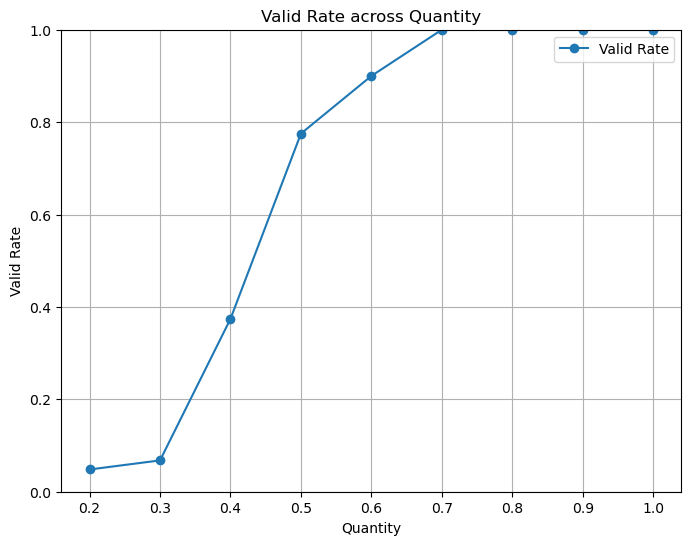

valid_call_rate


,player,valid_calls,invalid_calls,total_calls,valid_call_rate
0,player0,807,7,814,99.14%
1,player1,344,422,766,44.91%
2,player2,458,360,818,55.99%
3,player3,482,295,777,62.03%
4,player4,530,295,825,64.24%


In [59]:
#check 
print("dice distribution")
print(validation_test.check_original_dices())
print("\n" * 2)
print(print("win rate distribution"))
print(validation_test.check_win_rate())
print("\n" * 2)
print("first player distribution")
print(validation_test.check_first_player())
print("\n" * 2)
print("challenge bid distribution for player0")
validation_test.check_liar_call(0)
print("\n" * 2)
print("challenge bid distribution for player1")
validation_test.check_liar_call(1)
print("liar valid rate for player0")
validation_test.check_liar_valid_rate(0)
print("\n" * 2)
print("liar valid rate for player1")
validation_test.check_liar_valid_rate(1)
print("valid_call_rate")
validation_test.check_liar_win_rate()

### 5.1 prefer_bid + optimal_threshold Strategy vs. prefer_bid + normal_threshold Strategy


In [63]:
# Simulate the game with 5 players and each player has 5 dice
num_players = 5
num_dice = 5
times = 1000  
validation_test = valid.Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    if i == 0:
        #Player 0 uses the prefer_bid combinging optimal_threshold Strategy
        Strategies[i] = stra.Strategy(liar_threshold = "Normal", prefer_bid = True)
    elif i == 1:
        #Player 1 uses the prefer_bid combinging normal_threshold Strategy
        Strategies[i] = stra.Strategy(liar_threshold = "Optimal", prefer_bid = True)
    else:
        Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice, Strategies, first_caller = -1, special_rule = False)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4114          16.46%
1           2        4133          16.53%
2           3        4222          16.89%
3           4        4116          16.46%
4           5        4205          16.82%
5           6        4210          16.84%



win rate distribution
None
    Player  Wins Win Rate
0  player0   358   35.80%
1  player1   438   43.80%
2  player2    67    6.70%
3  player3    68    6.80%
4  player4    69    6.90%



first player distribution
    Player  Start times Start rate
0  player0          198     19.80%
1  player1          200     20.00%
2  player2          206     20.60%
3  player3          193     19.30%
4  player4          203     20.30%



challenge bid distribution for player0
    quantity  face_value  times  valid_times  invalid_times
65       1.0           6     77           77              0
64       1.0           5     40           40              0
53       0.8           6     38          

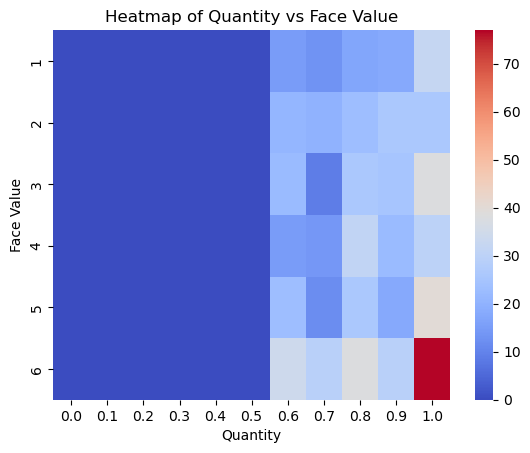




challenge bid distribution for player1
    quantity  face_value  times  valid_times  invalid_times
35       0.5           6     51           41             10
33       0.5           4     50           37             13
31       0.5           2     49           44              5
34       0.5           5     44           32             12
49       0.8           2     41           41              0
..       ...         ...    ...          ...            ...
13       0.2           2      0            0              0
15       0.2           4      0            0              0
14       0.2           3      0            0              0
16       0.2           5      0            0              0
0        0.0           1      0            0              0

[66 rows x 5 columns]


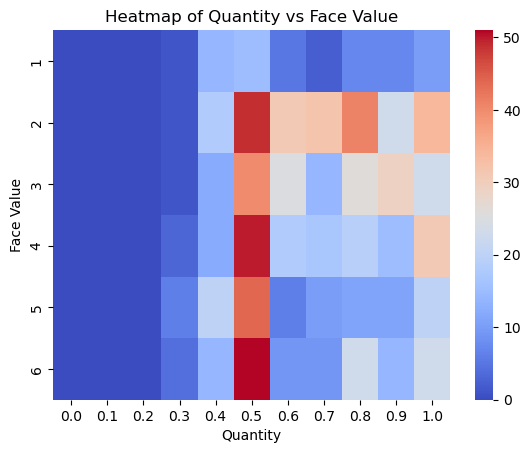

liar valid rate for player0
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2           0            0              0         NaN
0.3           0            0              0         NaN
0.4           0            0              0         NaN
0.5           0            0              0         NaN
0.6         130          109             21    0.838462
0.7          97           93              4    0.958763
0.8         161          160              1    0.993789
0.9         138          138              0    1.000000
1.0         243          243              0    1.000000


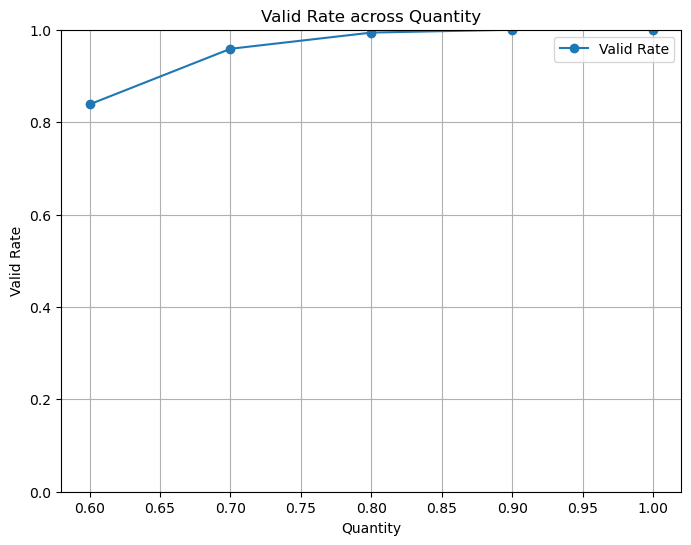




liar valid rate for player1
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2           0            0              0         NaN
0.3          16            9              7    0.562500
0.4          90           62             28    0.688889
0.5         249          200             49    0.803213
0.6          94           83             11    0.882979
0.7          84           82              2    0.976190
0.8         127          127              0    1.000000
0.9          99           99              0    1.000000
1.0         141          141              0    1.000000


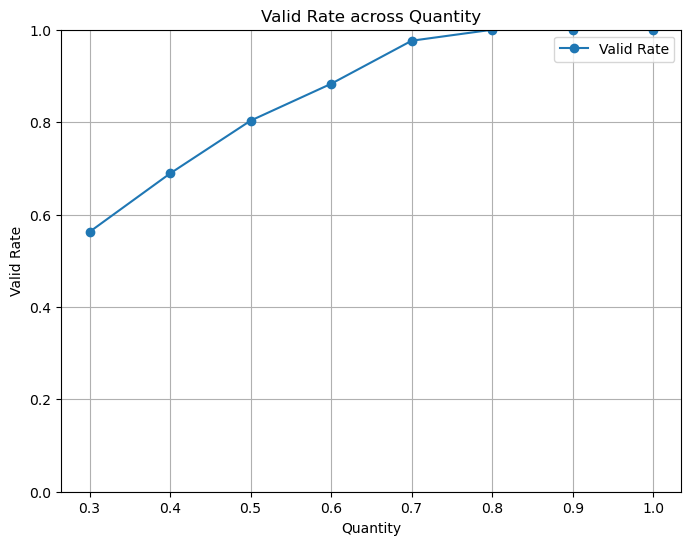

valid_call_rate


,player,valid_calls,invalid_calls,total_calls,valid_call_rate
0,player0,743,26,769,96.62%
1,player1,803,97,900,89.22%
2,player2,348,439,787,44.22%
3,player3,422,332,754,55.97%
4,player4,480,310,790,60.76%


In [66]:
#check 
print("dice distribution")
print(validation_test.check_original_dices())
print("\n" * 2)
print(print("win rate distribution"))
print(validation_test.check_win_rate())
print("\n" * 2)
print("first player distribution")
print(validation_test.check_first_player())
print("\n" * 2)
print("challenge bid distribution for player0")
validation_test.check_liar_call(0)
print("\n" * 2)
print("challenge bid distribution for player1")
validation_test.check_liar_call(1)
print("liar valid rate for player0")
validation_test.check_liar_valid_rate(0)
print("\n" * 2)
print("liar valid rate for player1")
validation_test.check_liar_valid_rate(1)
print("valid_call_rate")
validation_test.check_liar_win_rate()

### 6. Test for Conservative Increase Strategy
The Conservative Increase Hypothesis posits that a player who adopts a strategy of only incrementing the bid quantity by 1 per turn, rather than making larger or random increases, will achieve a higher success rate in the game. This approach reduces risk while maintaining competitive bids, potentially leading to a more consistent game outcome.

In [70]:
# Simulate the game with 5 players and each player has 5 dice (some players use random strategies and one uses conservative_increase strategy)
num_players = 5
num_dice = 5
times = 1000  
validation_test = valid.Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    if i == 0:
        Strategies[i] = stra.Strategy(conservative_increase = True)
    else:
        Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice, Strategies, first_caller = -1, special_rule = False)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4145          16.58%
1           2        4110          16.44%
2           3        4164          16.66%
3           4        4253          17.01%
4           5        4141          16.56%
5           6        4187          16.75%



win rate distribution
None
    Player  Wins Win Rate
0  player0   223   22.30%
1  player1   193   19.30%
2  player2   193   19.30%
3  player3   191   19.10%
4  player4   200   20.00%



first player distribution
    Player  Start times Start rate
0  player0          184     18.40%
1  player1          194     19.40%
2  player2          219     21.90%
3  player3          206     20.60%
4  player4          197     19.70%



challenge bid distribution for player0
    quantity  face_value  times  valid_times  invalid_times
65       1.0           6     50           50              0
29       0.4           6     40           26             14
28       0.4           5     33          

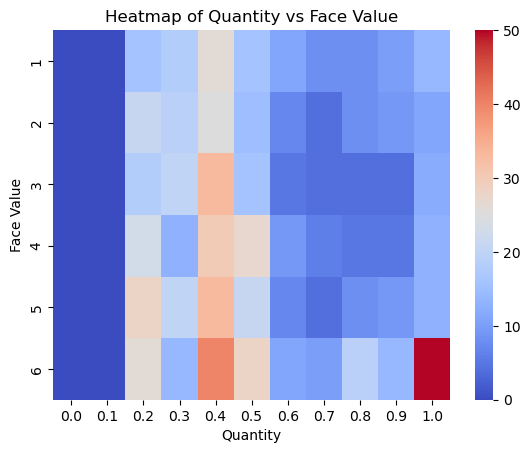




challenge bid distribution for player1
    quantity  face_value  times  valid_times  invalid_times
65       1.0           6     53           53              0
29       0.4           6     37           21             16
25       0.4           2     33           22             11
35       0.5           6     32           24              8
12       0.2           1     31           15             16
..       ...         ...    ...          ...            ...
3        0.0           4      0            0              0
11       0.1           6      0            0              0
10       0.1           5      0            0              0
9        0.1           4      0            0              0
0        0.0           1      0            0              0

[66 rows x 5 columns]


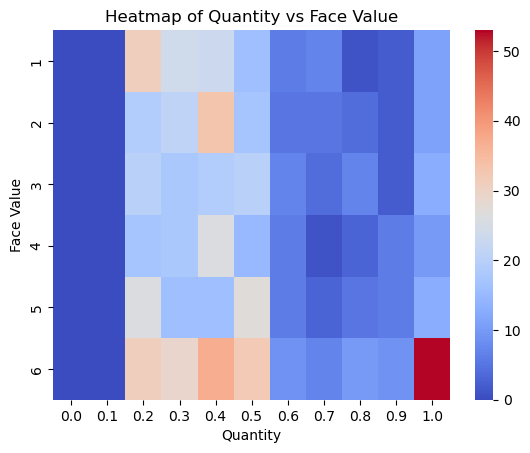

liar valid rate for player0
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2         132           12            120    0.090909
0.3         104           33             71    0.317308
0.4         187          111             76    0.593583
0.5         123          106             17    0.861789
0.6          50           49              1    0.980000
0.7          36           36              0    1.000000
0.8          52           52              0    1.000000
0.9          51           51              0    1.000000
1.0         113          113              0    1.000000


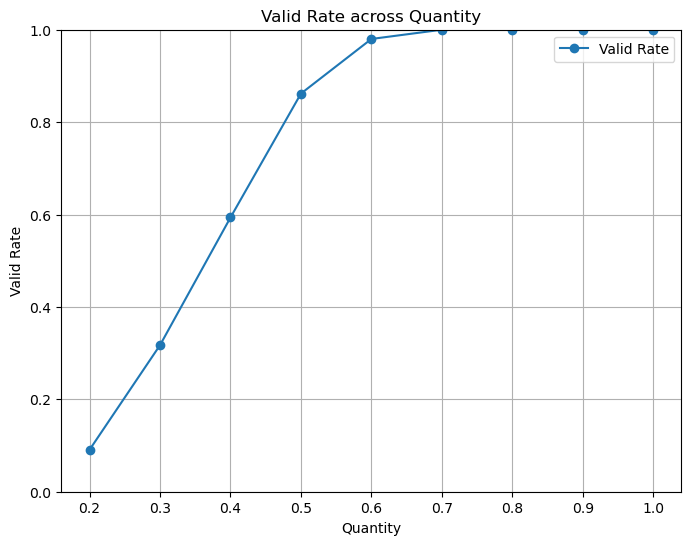




liar valid rate for player1
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2         144           21            123    0.145833
0.3         126           37             89    0.293651
0.4         154           99             55    0.642857
0.5         127          105             22    0.826772
0.6          39           37              2    0.948718
0.7          27           27              0    1.000000
0.8          30           30              0    1.000000
0.9          27           27              0    1.000000
1.0         111          111              0    1.000000


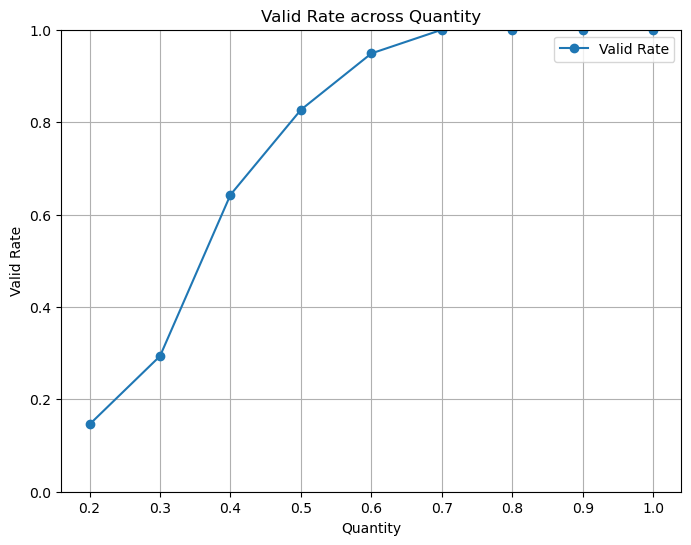

valid_call_rate


,player,valid_calls,invalid_calls,total_calls,valid_call_rate
0,player0,563,285,848,66.39%
1,player1,494,291,785,62.93%
2,player2,503,276,779,64.57%
3,player3,527,280,807,65.30%
4,player4,516,265,781,66.07%


In [72]:
#check 
print("dice distribution")
print(validation_test.check_original_dices())
print("\n" * 2)
print(print("win rate distribution"))
print(validation_test.check_win_rate())
print("\n" * 2)
print("first player distribution")
print(validation_test.check_first_player())
print("\n" * 2)
print("challenge bid distribution for player0")
validation_test.check_liar_call(0)
print("\n" * 2)
print("challenge bid distribution for player1")
validation_test.check_liar_call(1)
print("liar valid rate for player0")
validation_test.check_liar_valid_rate(0)
print("\n" * 2)
print("liar valid rate for player1")
validation_test.check_liar_valid_rate(1)
print("valid_call_rate")
validation_test.check_liar_win_rate()

### 7. Test for Prefer-Bid Using Conservative Increase Strategy
The Prefer-Bid with Conservative Increase Hypothesis posits that a player who use prefer_bid strategy and increases bid quantity conservatively (e.g., by only adding 1 to the previous quantity per turn instead of random increases) will outperform opponents using random strategies. This strategy focuses on controlled bidding to minimize unnecessary risks while leveraging known dice probabilities.

In [74]:
# Simulate the game with 5 players and each player has 5 dice (some players use random strategies and one uses prefer_bid and conservative_increase strategy)
num_players = 5
num_dice = 5
times = 1000  
validation_test = valid.Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    if i == 0:
        Strategies[i] = stra.Strategy(prefer_bid =  True, conservative_increase = True)
    else:
        Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice, Strategies, first_caller = -1, special_rule = False)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4218          16.87%
1           2        4148          16.59%
2           3        4231          16.92%
3           4        4129          16.52%
4           5        4121          16.48%
5           6        4153          16.61%



win rate distribution
None
    Player  Wins Win Rate
0  player0   346   34.60%
1  player1   142   14.20%
2  player2   173   17.30%
3  player3   158   15.80%
4  player4   181   18.10%



first player distribution
    Player  Start times Start rate
0  player0          224     22.40%
1  player1          195     19.50%
2  player2          174     17.40%
3  player3          203     20.30%
4  player4          204     20.40%



challenge bid distribution for player0
    quantity  face_value  times  valid_times  invalid_times
65       1.0           6     47           47              0
29       0.4           6     42           21             21
20       0.3           3     34          

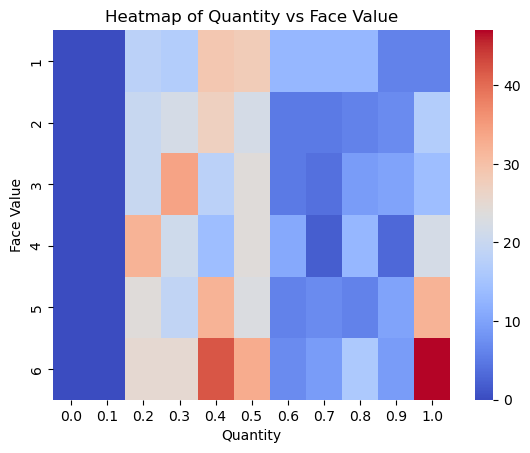




challenge bid distribution for player1
    quantity  face_value  times  valid_times  invalid_times
25       0.4           2     43           15             28
26       0.4           3     41           19             22
65       1.0           6     35           35              0
17       0.2           6     35            2             33
31       0.5           2     35           24             11
..       ...         ...    ...          ...            ...
44       0.7           3      0            0              0
11       0.1           6      0            0              0
10       0.1           5      0            0              0
54       0.9           1      0            0              0
0        0.0           1      0            0              0

[66 rows x 5 columns]


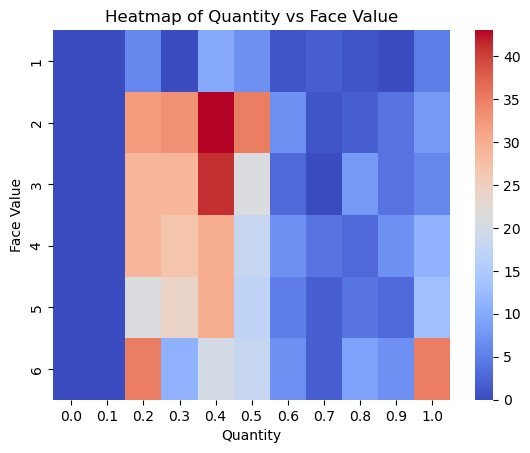

liar valid rate for player0
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2         139            9            130    0.064748
0.3         138           39             99    0.282609
0.4         162          105             57    0.648148
0.5         154          127             27    0.824675
0.6          47           44              3    0.936170
0.7          40           40              0    1.000000
0.8          63           63              0    1.000000
0.9          45           45              0    1.000000
1.0         138          138              0    1.000000


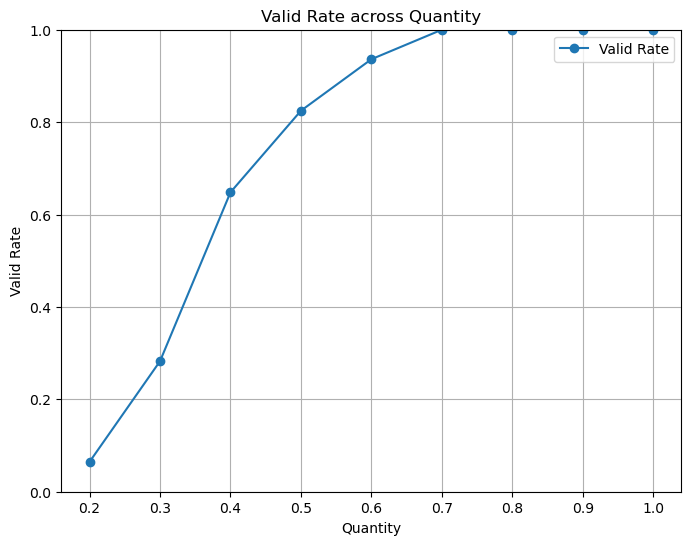




liar valid rate for player1
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2         152            4            148    0.026316
0.3         124           18            106    0.145161
0.4         174           73            101    0.419540
0.5         116           87             29    0.750000
0.6          30           24              6    0.800000
0.7          11           11              0    1.000000
0.8          27           27              0    1.000000
0.9          25           25              0    1.000000
1.0          78           78              0    1.000000


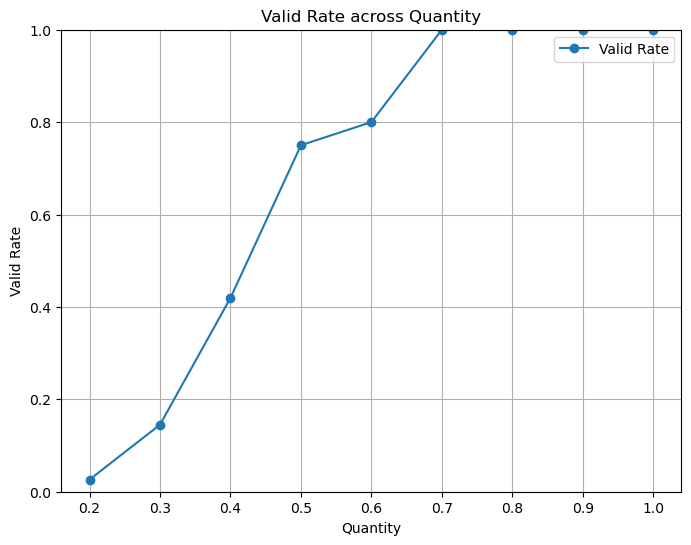

valid_call_rate


,player,valid_calls,invalid_calls,total_calls,valid_call_rate
0,player0,610,316,926,65.87%
1,player1,347,390,737,47.08%
2,player2,445,299,744,59.81%
3,player3,484,289,773,62.61%
4,player4,512,308,820,62.44%


In [76]:
#check 
print("dice distribution")
print(validation_test.check_original_dices())
print("\n" * 2)
print(print("win rate distribution"))
print(validation_test.check_win_rate())
print("\n" * 2)
print("first player distribution")
print(validation_test.check_first_player())
print("\n" * 2)
print("challenge bid distribution for player0")
validation_test.check_liar_call(0)
print("\n" * 2)
print("challenge bid distribution for player1")
validation_test.check_liar_call(1)
print("liar valid rate for player0")
validation_test.check_liar_valid_rate(0)
print("\n" * 2)
print("liar valid rate for player1")
validation_test.check_liar_valid_rate(1)
print("valid_call_rate")
validation_test.check_liar_win_rate()

### Test for different strtegies


In [86]:
# Simulate the game with 5 players and each player has 5 dice
num_players = 5
num_dice = 5
times = 1000  
validation_test = valid.Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    if i == 0:
        Strategies[i] = stra.Strategy(liar_threshold = "Normal")
    elif i == 1:
        Strategies[i] = stra.Strategy(liar_threshold = "Optimal")
    elif i == 2:
        Strategies[i] = stra.Strategy(prefer_bid = True)
    elif i == 3:
        Strategies[i] = stra.Strategy(liar_threshold = "Normal",prefer_bid = True)
    elif i == 4:
        Strategies[i] = stra.Strategy(liar_threshold = "Optimal",prefer_bid = True)
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice, Strategies, first_caller = -1, special_rule = False)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4127          16.51%
1           2        4150          16.60%
2           3        4228          16.91%
3           4        4094          16.38%
4           5        4222          16.89%
5           6        4179          16.72%



win rate distribution
None
    Player  Wins Win Rate
0  player0    77    7.70%
1  player1   169   16.90%
2  player2    78    7.80%
3  player3   265   26.50%
4  player4   411   41.10%



first player distribution
    Player  Start times Start rate
0  player0          195     19.50%
1  player1          220     22.00%
2  player2          215     21.50%
3  player3          188     18.80%
4  player4          182     18.20%



challenge bid distribution for player0
    quantity  face_value  times  valid_times  invalid_times
37       0.6           2     30           28              2
61       1.0           2     28           28              0
49       0.8           2     26          

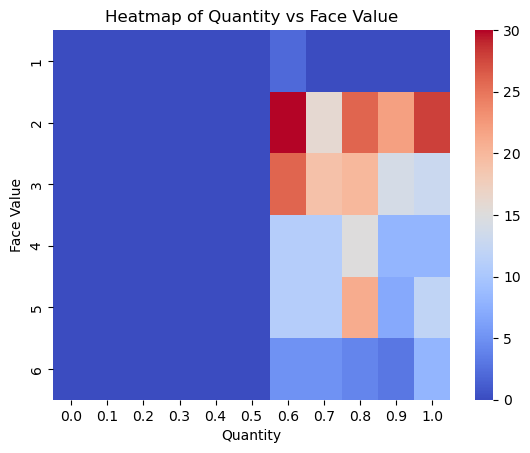

challenge bid distribution for player1
    quantity  face_value  times  valid_times  invalid_times
35       0.5           6     43           32             11
65       1.0           6     42           42              0
38       0.6           3     38           37              1
32       0.5           3     33           26              7
34       0.5           5     33           23             10
..       ...         ...    ...          ...            ...
12       0.2           1      0            0              0
14       0.2           3      0            0              0
15       0.2           4      0            0              0
16       0.2           5      0            0              0
0        0.0           1      0            0              0

[66 rows x 5 columns]


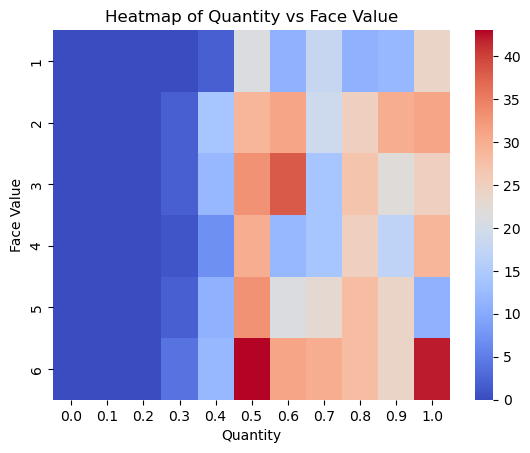

challenge bid distribution for player2
    quantity  face_value  times  valid_times  invalid_times
29       0.4           6     64           32             32
35       0.5           6     51           37             14
23       0.3           6     37            6             31
16       0.2           5     29            1             28
17       0.2           6     29            0             29
..       ...         ...    ...          ...            ...
8        0.1           3      0            0              0
11       0.1           6      0            0              0
10       0.1           5      0            0              0
9        0.1           4      0            0              0
0        0.0           1      0            0              0

[66 rows x 5 columns]


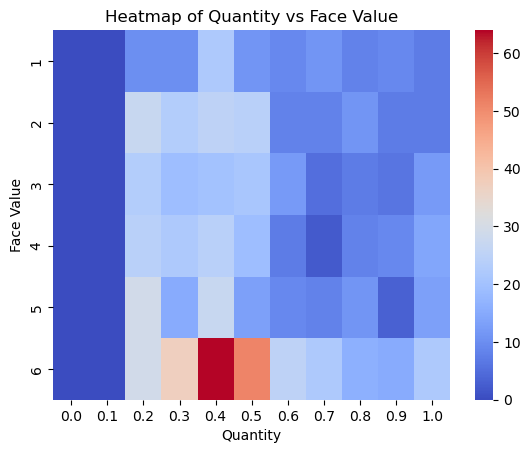

challenge bid distribution for player3
    quantity  face_value  times  valid_times  invalid_times
61       1.0           2     75           75              0
62       1.0           3     53           53              0
65       1.0           6     47           47              0
53       0.8           6     41           41              0
49       0.8           2     36           36              0
..       ...         ...    ...          ...            ...
13       0.2           2      0            0              0
15       0.2           4      0            0              0
14       0.2           3      0            0              0
8        0.1           3      0            0              0
0        0.0           1      0            0              0

[66 rows x 5 columns]


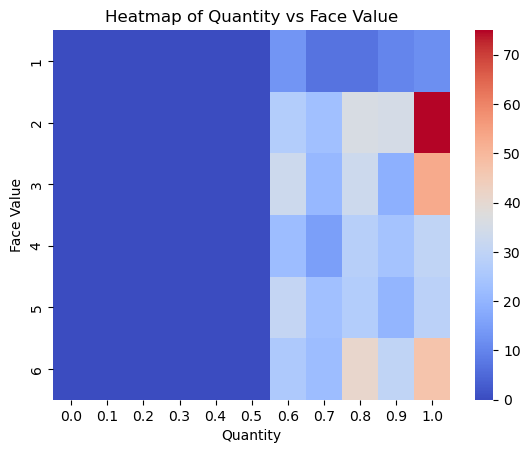

challenge bid distribution for player4
    quantity  face_value  times  valid_times  invalid_times
31       0.5           2     58           48             10
32       0.5           3     52           49              3
61       1.0           2     52           52              0
34       0.5           5     49           41              8
33       0.5           4     49           38             11
..       ...         ...    ...          ...            ...
12       0.2           1      0            0              0
14       0.2           3      0            0              0
15       0.2           4      0            0              0
16       0.2           5      0            0              0
0        0.0           1      0            0              0

[66 rows x 5 columns]


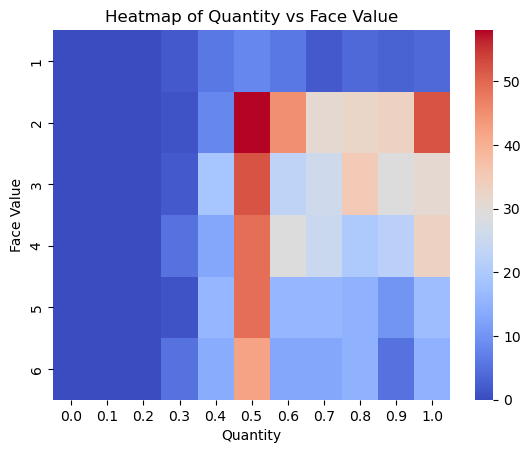




challenge bid distribution for player0
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2           0            0              0         NaN
0.3           0            0              0         NaN
0.4           0            0              0         NaN
0.5           0            0              0         NaN
0.6          85           76              9    0.894118
0.7          62           61              1    0.983871
0.8          86           85              1    0.988372
0.9          54           54              0    1.000000
1.0          69           69              0    1.000000


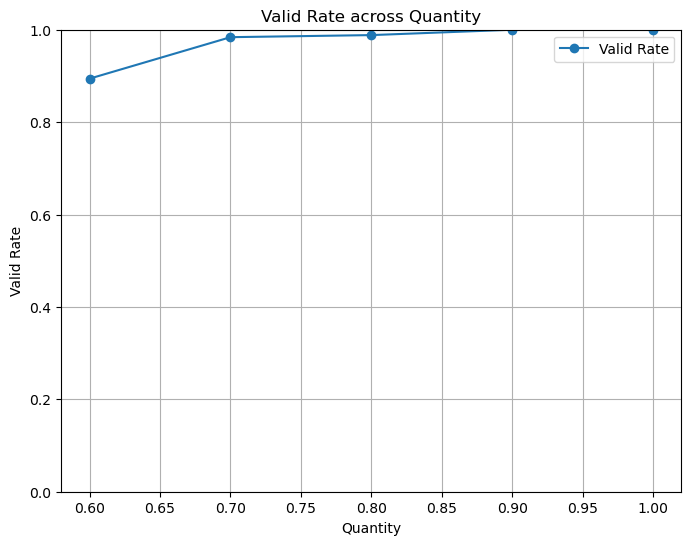

challenge bid distribution for player1
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2           0            0              0         NaN
0.3          11            7              4    0.636364
0.4          58           40             18    0.689655
0.5         189          148             41    0.783069
0.6         144          141              3    0.979167
0.7         118          115              3    0.974576
0.8         144          144              0    1.000000
0.9         129          128              1    0.992248
1.0         162          162              0    1.000000


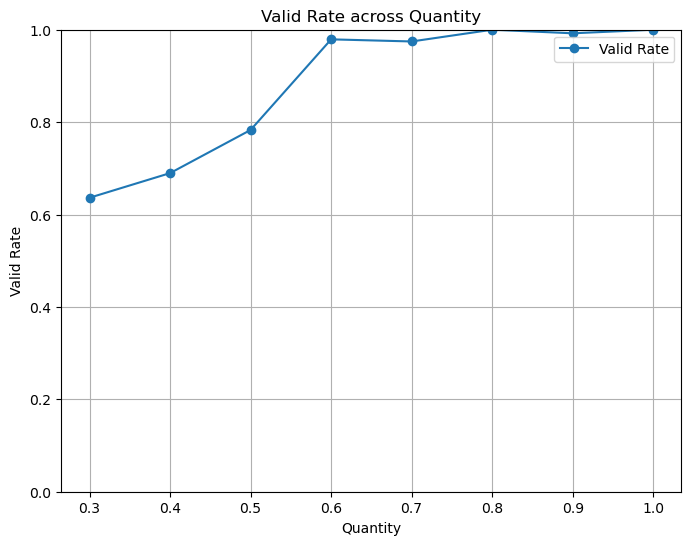

challenge bid distribution for player2
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2         142            9            133    0.063380
0.3         126           30             96    0.238095
0.4         182          101             81    0.554945
0.5         139          107             32    0.769784
0.6          70           68              2    0.971429
0.7          56           55              1    0.982143
0.8          61           60              1    0.983607
0.9          49           49              0    1.000000
1.0          75           75              0    1.000000


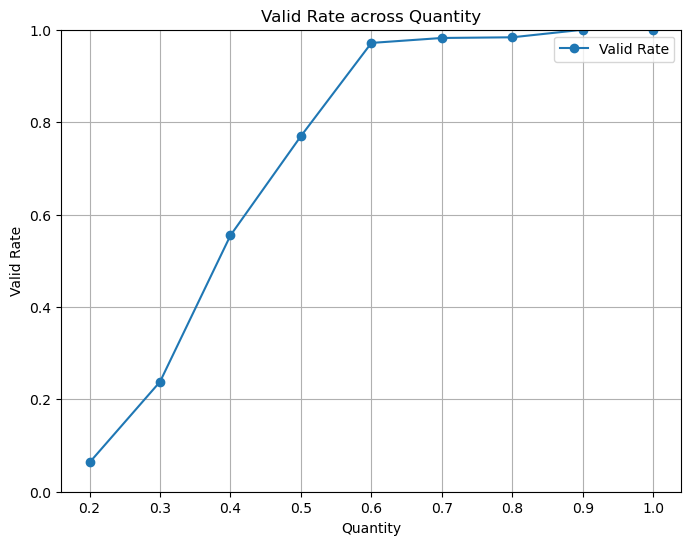

challenge bid distribution for player3
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2           0            0              0         NaN
0.3           0            0              0         NaN
0.4           0            0              0         NaN
0.5           0            0              0         NaN
0.6         152          130             22    0.855263
0.7         111          107              4    0.963964
0.8         172          172              0    1.000000
0.9         138          138              0    1.000000
1.0         246          246              0    1.000000


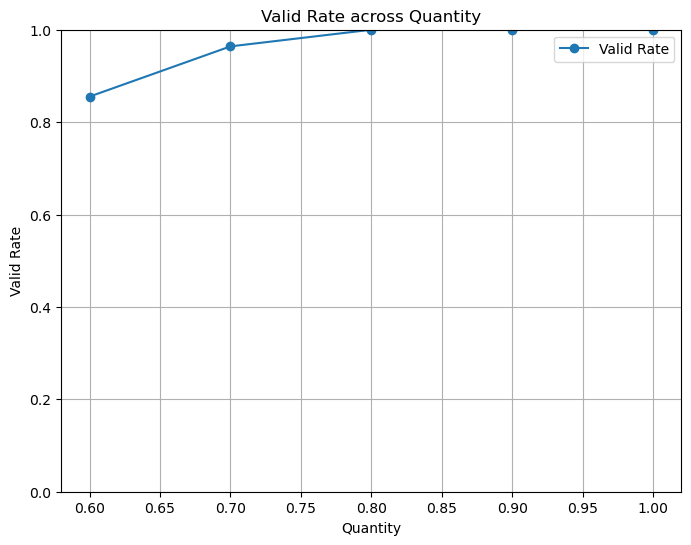

challenge bid distribution for player4
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2           0            0              0         NaN
0.3          16           10              6    0.625000
0.4          76           60             16    0.789474
0.5         258          221             37    0.856589
0.6         132          124              8    0.939394
0.7         113          112              1    0.991150
0.8         121          120              1    0.991736
0.9         102          102              0    1.000000
1.0         152          152              0    1.000000


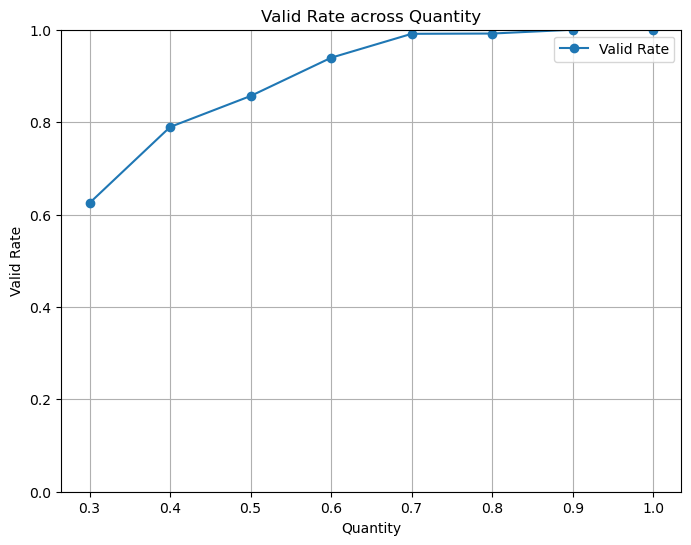

challenge bid distribution for player1



valid_call_rate


,player,valid_calls,invalid_calls,total_calls,valid_call_rate
0,player0,345,11,356,96.91%
1,player1,885,70,955,92.67%
2,player2,554,346,900,61.56%
3,player3,793,26,819,96.83%
4,player4,901,69,970,92.89%


In [88]:
#check 
print("dice distribution")
print(validation_test.check_original_dices())
print("\n" * 2)
print(print("win rate distribution"))
print(validation_test.check_win_rate())
print("\n" * 2)
print("first player distribution")
print(validation_test.check_first_player())
print("\n" * 2)
for i in range(num_players):
    print(f"challenge bid distribution for player{i}")
    validation_test.check_liar_call(i)
print("\n" * 2)
for i in range(num_players):
    print(f"challenge bid distribution for player{i}")
    validation_test.check_liar_valid_rate(i)
print("\n" * 2)
print("valid_call_rate")
validation_test.check_liar_win_rate()

### Test hypothesis for special rule

In [78]:
# Simulate the game with 5 players and each player has 5 dice (everyone uses random strategies,but plays under special rule)
num_players = 5
num_dice = 5
times = 1000  
validation_test = valid.Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    if i == 0:
        Strategies[i] = stra.Strategy(liar_threshold = "Normal")
    else:
        Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = (game.simulate_game(num_players, num_dice, Strategies, first_caller = -1, special_rule = True))
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4136          16.54%
1           2        4259          17.04%
2           3        4166          16.66%
3           4        4117          16.47%
4           5        4167          16.67%
5           6        4155          16.62%



win rate distribution
None
    Player  Wins Win Rate
0  player0   463   46.30%
1  player1   121   12.10%
2  player2   139   13.90%
3  player3   119   11.90%
4  player4   158   15.80%



first player distribution
    Player  Start times Start rate
0  player0          180     18.00%
1  player1          198     19.80%
2  player2          217     21.70%
3  player3          203     20.30%
4  player4          202     20.20%



challenge bid distribution for player0
    quantity  face_value  times  valid_times  invalid_times
29       0.4           6    236          233              3
41       0.6           6    212          212              0
35       0.5           6    169          

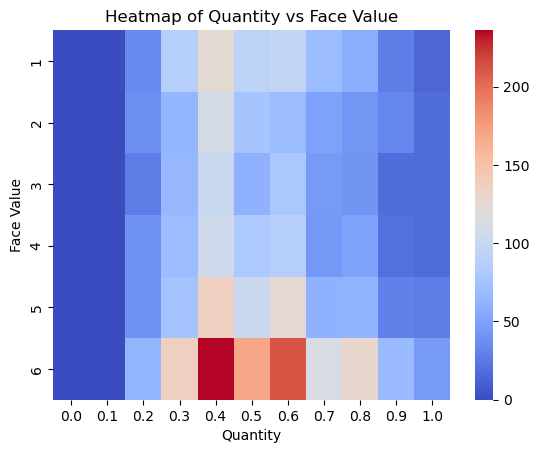




challenge bid distribution for player1
    quantity  face_value  times  valid_times  invalid_times
17       0.2           6    368          131            237
16       0.2           5    253           88            165
15       0.2           4    244           77            167
29       0.4           6    238          203             35
14       0.2           3    214           74            140
..       ...         ...    ...          ...            ...
3        0.0           4      0            0              0
0        0.0           1      0            0              0
1        0.0           2      0            0              0
4        0.0           5      0            0              0
5        0.0           6      0            0              0

[66 rows x 5 columns]


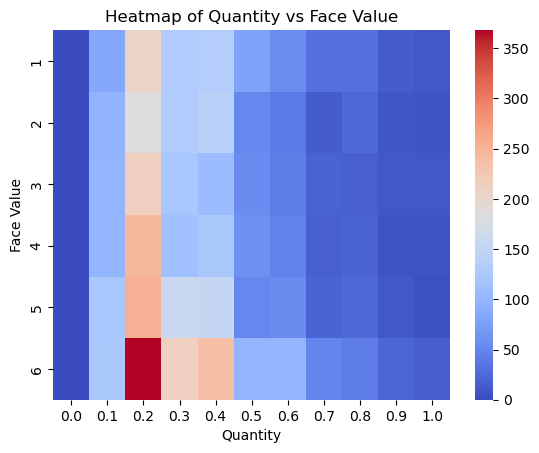

liar valid rate for player0
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1           0            0              0         NaN
0.2         241          205             36    0.850622
0.3         498          468             30    0.939759
0.4         813          799             14    0.982780
0.5         581          578              3    0.994836
0.6         670          669              1    0.998507
0.7         380          380              0    1.000000
0.8         381          381              0    1.000000
0.9         195          195              0    1.000000
1.0         137          137              0    1.000000


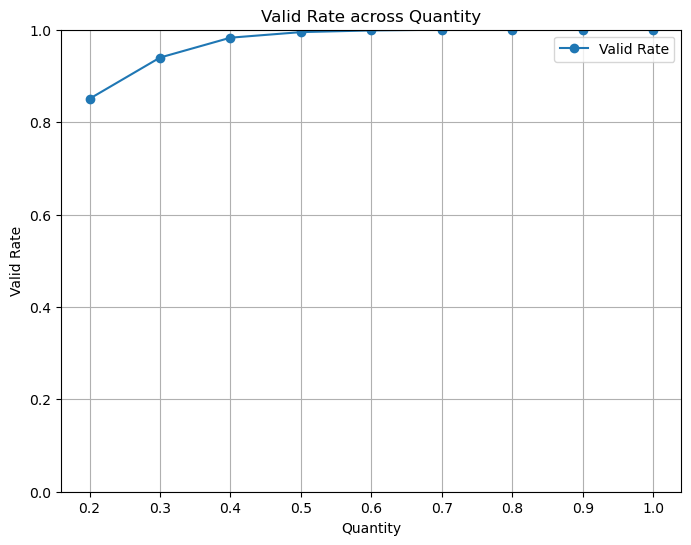




liar valid rate for player1
          times  valid_times  invalid_times  valid_rate
quantity                                               
0.0           0            0              0         NaN
0.1         624          110            514    0.176282
0.2        1470          604            866    0.410884
0.3         866          589            277    0.680139
0.4         897          782            115    0.871795
0.5         395          382             13    0.967089
0.6         341          341              0    1.000000
0.7         152          152              0    1.000000
0.8         154          154              0    1.000000
0.9          70           70              0    1.000000
1.0          52           52              0    1.000000


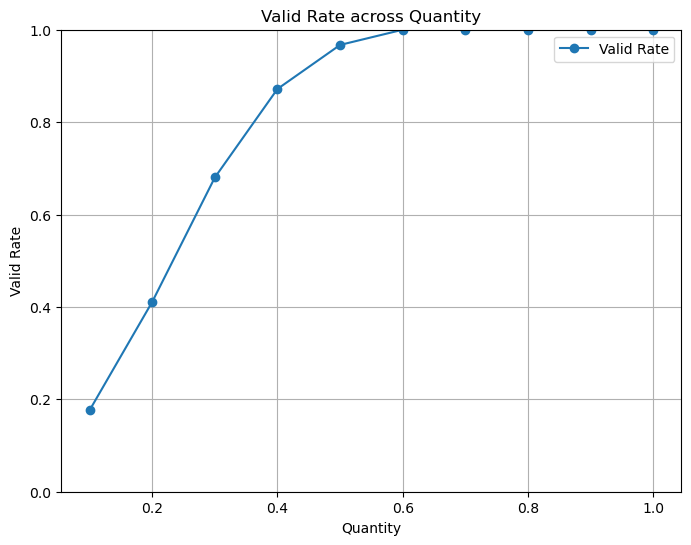

valid_call_rate


,player,valid_calls,invalid_calls,total_calls,valid_call_rate
0,player0,3812,84,3896,97.84%
1,player1,3236,1785,5021,64.45%
2,player2,3199,1502,4701,68.05%
3,player3,3189,1596,4785,66.65%
4,player4,3133,1476,4609,67.98%


In [84]:
#check 
print("dice distribution")
print(validation_test.check_original_dices())
print("\n" * 2)
print(print("win rate distribution"))
print(validation_test.check_win_rate())
print("\n" * 2)
print("first player distribution")
print(validation_test.check_first_player())
print("\n" * 2)
print("challenge bid distribution for player0")
validation_test.check_liar_call(0)
print("\n" * 2)
print("challenge bid distribution for player1")
validation_test.check_liar_call(1)
print("liar valid rate for player0")
validation_test.check_liar_valid_rate(0)
print("\n" * 2)
print("liar valid rate for player1")
validation_test.check_liar_valid_rate(1)
print("valid_call_rate")
validation_test.check_liar_win_rate()